In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sys

In [2]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('dt', 40), ('np', 40), ('pd', 40), ('plt', 40)]

In [5]:
# Read data
df = pd.read_csv('/home/sachin199/personal projects/Session-based-e-commerce-analysis/preprocessed_data/filtered_data.csv',header=0,parse_dates=['event_time'],infer_datetime_format=True)

In [6]:
df_copy = df.copy()
df_copy['event_type'] = df_copy['event_type'].astype('category')
df_copy = df_copy[df_copy.price > 0]
df_copy = df_copy.sort_values(['user_id','product_id','event_time'])
df_copy.head(10)
del df

In [7]:
# retain user-product combinations with cart event_type
df_copy = df_copy.merge(df_copy.loc[df_copy.event_type=='cart',['product_id','user_id']].drop_duplicates() \
                        ,on=['product_id','user_id'],how='inner')
df_copy.sort_values(['user_id','product_id','event_time']).head(10)

,event_time,event_type,product_id,category_id,price,user_id,user_session
0,2019-10-21 21:05:31,cart,5815653,1487580006317032337,0.67,4103071,8930ec72-36b0-4be9-80c7-af93b9f477c6
1,2019-11-11 18:03:18,view,49674,1487580006317032337,1.11,5493470,dad8b91c-b700-4be1-9f14-e80af656d441
2,2019-11-11 18:03:41,cart,49674,1487580006317032337,1.11,5493470,dad8b91c-b700-4be1-9f14-e80af656d441
3,2019-11-11 18:02:09,view,5745712,1487580006317032337,8.73,5493470,dad8b91c-b700-4be1-9f14-e80af656d441
4,2019-11-11 18:02:35,cart,5745712,1487580006317032337,8.73,5493470,dad8b91c-b700-4be1-9f14-e80af656d441
5,2019-10-01 21:26:32,cart,5739030,1645114480121610699,3.97,8846226,ddd23270-792c-49f3-9ae2-d86f5080a5eb
6,2019-10-01 21:23:03,cart,5739036,1487580008246412266,3.32,8846226,ddd23270-792c-49f3-9ae2-d86f5080a5eb
7,2019-10-01 22:06:07,remove_from_cart,5739036,1487580008246412266,3.32,8846226,ddd23270-792c-49f3-9ae2-d86f5080a5eb
8,2019-10-01 21:27:29,cart,5739057,1487580008263189483,4.75,8846226,ddd23270-792c-49f3-9ae2-d86f5080a5eb
9,2019-10-02 14:45:01,remove_from_cart,5739057,1487580008263189483,4.75,8846226,f835c9a8-cb8a-4201-85d4-00565bcc84ad


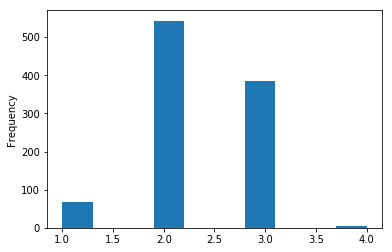

In [8]:
# number of changes in price
df_copy.groupby(['product_id']).price.apply(lambda x: len(set(x))).reset_index().price.plot.hist()

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


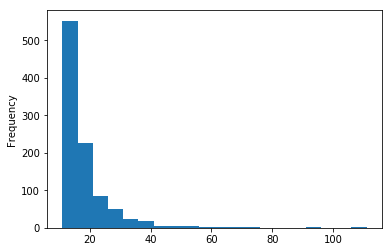

In [9]:
# user-product combination for cart event_type distribution
df_copy.loc[df_copy.event_type == 'cart', :] \
    .groupby(['user_id','product_id']).user_session.count().reset_index() \
    .query('user_session>10').user_session.plot.hist(bins=20)

# feature engineering

In [10]:
last_cart_df = df_copy.loc[df_copy.event_type =='cart',['user_id','product_id','event_time']] \
    .groupby(['user_id','product_id']).event_time.last().reset_index() \
    .rename(columns={'event_time':'last_cart_time'})
df_copy = df_copy.merge(last_cart_df,on=['user_id','product_id'],how='inner')
del last_cart_df

In [11]:
demand_df = df_copy.copy()
demand_df['year'] = demand_df.event_time.dt.year
demand_df['month'] = demand_df.event_time.dt.month
demand_df['day'] = demand_df.event_time.dt.day
demand_df = demand_df.groupby(['product_id','year','month','day']) \
    .agg({'user_session':'nunique'}).reset_index()
demand_df['date'] = pd.to_datetime(demand_df[['year','month','day']])
window_size=3
for w in range(1,window_size+1):
    demand_df['shift_'+str(w)] = demand_df.user_session.shift(periods=w)
demand_df = demand_df.dropna()
demand_df['prev_'+str(window_size)] = 0
for w in range(1,window_size+1):
     demand_df['prev_'+str(window_size)] += demand_df['shift_'+str(w)]
demand_df['prev_3'] = demand_df['prev_3'].astype('int')
demand_df = demand_df[['product_id','date','prev_3']]
demand_df.head()

,product_id,date,prev_3
3,3762,2019-10-04,32
4,3762,2019-10-05,34
5,3762,2019-10-06,32
6,3762,2019-10-07,31
7,3762,2019-10-08,30


In [12]:
feature_df = df_copy.loc[df_copy.event_time <= df_copy.last_cart_time, ['user_id','product_id','price','event_type','user_session','event_time']]
label_df = df_copy.loc[df_copy.event_time > df_copy.last_cart_time, ['user_id','product_id','event_type']]

In [13]:
for event in list(feature_df.event_type.unique()):
    feature_df[event] = (feature_df.event_type == event)
feature_df.head()

,user_id,product_id,price,event_type,user_session,event_time,cart,view,remove_from_cart,purchase
0,4103071,5815653,0.67,cart,8930ec72-36b0-4be9-80c7-af93b9f477c6,2019-10-21 21:05:31,True,False,False,False
1,5493470,49674,1.11,view,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:03:18,False,True,False,False
2,5493470,49674,1.11,cart,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:03:41,True,False,False,False
3,5493470,5745712,8.73,view,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:02:09,False,True,False,False
4,5493470,5745712,8.73,cart,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:02:35,True,False,False,False


In [14]:
feature_df.head()

,user_id,product_id,price,event_type,user_session,event_time,cart,view,remove_from_cart,purchase
0,4103071,5815653,0.67,cart,8930ec72-36b0-4be9-80c7-af93b9f477c6,2019-10-21 21:05:31,True,False,False,False
1,5493470,49674,1.11,view,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:03:18,False,True,False,False
2,5493470,49674,1.11,cart,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:03:41,True,False,False,False
3,5493470,5745712,8.73,view,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:02:09,False,True,False,False
4,5493470,5745712,8.73,cart,dad8b91c-b700-4be1-9f14-e80af656d441,2019-11-11 18:02:35,True,False,False,False


In [15]:
feature_df = feature_df.sort_values(['user_id','product_id','event_time'])

agg_func = dict()
agg_func['price'] = ['first','mean','last']
agg_func['event_type'] = 'count'
agg_func['user_session'] = 'nunique'
agg_func['event_time'] = ['first','last']
agg_func['cart'] = 'sum'
agg_func['view'] = 'sum'
agg_func['remove_from_cart'] = 'sum'
agg_func['purchase'] = 'sum'

feature_df = feature_df.groupby(['user_id','product_id']).agg(agg_func).reset_index()
feature_df.columns = ['_'.join(col) if col[1] != '' else ' '.join(col).strip() for col in feature_df.columns.values]

feature_df.head()

,user_id,product_id,cart_sum,remove_from_cart_sum,user_session_nunique,event_time_first,event_time_last,view_sum,price_first,price_mean,price_last,event_type_count,purchase_sum
0,4103071,5815653,1.0,0.0,1,2019-10-21 21:05:31,2019-10-21 21:05:31,0.0,0.67,0.67,0.67,1,0.0
1,5493470,49674,1.0,0.0,1,2019-11-11 18:03:18,2019-11-11 18:03:41,1.0,1.11,1.11,1.11,2,0.0
2,5493470,5745712,1.0,0.0,1,2019-11-11 18:02:09,2019-11-11 18:02:35,1.0,8.73,8.73,8.73,2,0.0
3,8846226,5739030,1.0,0.0,1,2019-10-01 21:26:32,2019-10-01 21:26:32,0.0,3.97,3.97,3.97,1,0.0
4,8846226,5739036,1.0,0.0,1,2019-10-01 21:23:03,2019-10-01 21:23:03,0.0,3.32,3.32,3.32,1,0.0


In [16]:
feature_df['date'] = pd.to_datetime(feature_df.event_time_last.dt.date)
feature_df = feature_df.merge(demand_df,on=['product_id','date'],how='inner')
del demand_df

In [17]:
feature_df['price_change_percent'] = (100 * (feature_df['price_last'] - feature_df['price_first']) / feature_df['price_first'])
feature_df['tenure'] = feature_df['event_time_last'].dt.dayofyear - feature_df['event_time_first'].dt.dayofyear
feature_df['day_of_week'] = feature_df['date'].dt.dayofweek
feature_df = feature_df[['user_id','product_id','event_type_count','user_session_nunique','view_sum','cart_sum','remove_from_cart_sum','purchase_sum','price_mean','price_last','price_change_percent','tenure','prev_3','day_of_week']]
feature_df.head()

,user_id,product_id,event_type_count,user_session_nunique,view_sum,cart_sum,remove_from_cart_sum,purchase_sum,price_mean,price_last,price_change_percent,tenure,prev_3,day_of_week
0,4103071,5815653,1,1,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0,99,0
1,248994993,5815653,1,1,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0,99,0
2,360779248,5815653,1,1,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0,99,0
3,440081226,5815653,1,1,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0,99,0
4,446363523,5815653,1,1,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0,99,0


In [22]:
label_df = label_df[label_df.event_type != 'view']
label_df['event_type'] = label_df.event_type.apply(lambda x: 1 if x == 'purchase' else -1)
label_df = label_df.groupby(['user_id','product_id']).agg({'event_type':'max'}).reset_index()
label_df.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [17]:
final_df = feature_df.merge(label_df,on=['user_id','product_id'],how='outer').fillna(0)

In [18]:
final_df.head()

,user_id,product_id,event_type_count,user_session_nunique,view_sum,cart_sum,remove_from_cart_sum,purchase_sum,price_mean,price_last,price_change_percent,tenure,prev_3,day_of_week,event_type
0,4103071,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,0.0
1,248994993,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,0.0
2,360779248,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,-1.0
3,440081226,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,1.0
4,446363523,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,0.0


In [19]:
final_df.columns = ['user_id','product_id','interactions','sessions','view','cart','remove_from_cart','purchase','avg_price','latest_price','price_change','tenure','demand','day_of_week','event_type']

In [20]:
final_df.shape

(445448, 15)

In [26]:
final_df.head()

,user_id,product_id,interactions,sessions,view,cart,remove_from_cart,purchase,avg_price,latest_price,price_change,tenure,demand,day_of_week,event_type
0,4103071,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,0.0
1,248994993,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,0.0
2,360779248,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,-1.0
3,440081226,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,1.0
4,446363523,5815653,1.0,1.0,0.0,1.0,0.0,0.0,0.67,0.67,0.0,0.0,99.0,0.0,0.0


In [30]:
del df_copy
del label_df
del feature_df

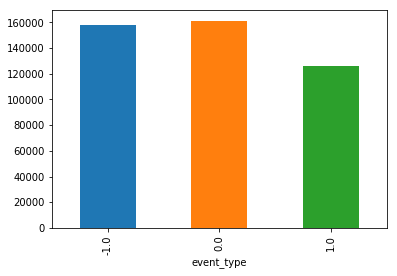

In [31]:
final_df.groupby('event_type').user_id.count().plot.bar()